# Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# models
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

# eval utils
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
# df = pd.read_csv('cats-no-breed-info.csv').drop(columns=['id', 'breed', 'color'])

# df = pd.read_csv('nc_m1_ag1_h1.csv')
# df = pd.read_csv('nc_m1_ag1_h2.csv')

# df = pd.read_csv('nc_m1_ag2_h1.csv', index_col=[0])
# df = pd.read_csv('nc_m1_ag3_h1.csv', index_col=[0])

# df = pd.read_csv('nc_m2_ag1_h1.csv')

# df = pd.read_csv('nc_m2_ag3_h1.csv').drop(columns=['hair_length'])
# df = pd.read_csv('nc_m1_ag3_h2.csv')

# df = pd.read_csv('nc_m2_ag3_h2.csv')

df = pd.read_csv('nd_avg.csv', index_col=[0])
df = df[df.columns.drop(list(df.filter(regex='breed_')))]
df = df.drop(columns=["Unnamed: 0"])
df.columns

df.head()


,intake_number,time_in_shelter_days,is_sterilized,is_sterilized_in_shelter,age_group_upon_intake,mixed_breed,dog_size,avg_height,avg_weight,avg_lifespan,...,in_month_5,in_month_6,in_month_7,in_month_8,in_month_9,in_month_10,in_month_11,in_month_12,is_puppy,age_upon_intake_days
0,0.0,49.747917,1,0,1.00000,1,0.5,0.038462,0.114427,0.777778,...,0,0,0,0,0,1,0,0,0,1.0
1,0.0,9.020139,1,0,1.00000,0,0.0,0.000000,0.000000,0.777778,...,0,0,0,0,1,0,0,0,0,1.0
2,0.0,23.104861,1,0,1.00000,1,1.0,0.576923,0.369608,0.444444,...,0,0,0,0,0,1,0,0,0,1.0
3,0.0,89.855556,1,0,1.00000,1,1.0,0.634615,0.472175,0.555556,...,0,0,0,1,0,0,0,0,0,1.0
4,0.0,2.755556,1,0,0.61831,1,1.0,0.692308,0.325557,0.777778,...,0,0,0,0,0,0,1,0,0,1.0


In [3]:
def get_time_period_labels_from_bins(bins):
    n_bins = len(bins)
    labels = []
    for i in range(n_bins - 1):
        label = f'{bins[i]}-{bins[i+1]} days' if i != n_bins - 2 else f'> {bins[i]} days'
        labels.append(label)
    return labels
    
def print_report(y_true, y_pred, target_names):
    print(classification_report(y_true, y_pred, target_names=target_names))


def fit_print(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    print_report(y_test, clf.predict(X_test), target_labels)

def plot_train_history(hist):
    plt.plot(hist.history['loss'], '-', label='Training loss')
    plt.plot(hist.history['val_loss'], '-', label='Validation loss')

    # add axis labels and title
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Training and Validation Loss')

    # add legend
    plt.legend()

    # show the plot
    plt.show()

In [4]:
bins = (0, 7, 30, 60, 90, 120, df['time_in_shelter_days'].max() + 1)

def bin_target(target):
    return np.digitize(target, bins) - 1

In [5]:
target_labels = get_time_period_labels_from_bins(bins)
target_labels

['0-7 days',
 '7-30 days',
 '30-60 days',
 '60-90 days',
 '90-120 days',
 '> 120 days']

In [6]:
df['target'] = bin_target(df['time_in_shelter_days'])
df['target'].value_counts()

0    9614
1    6157
2    1995
3     830
5     766
4     394
Name: target, dtype: int64

In [7]:
train, test = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=0)

X_train, y_train_orig = train.drop(columns=['time_in_shelter_days', 'target']), train['time_in_shelter_days']
X_test, y_test_orig = test.drop(columns=['time_in_shelter_days', 'target']), test['time_in_shelter_days']

y_train, y_test = bin_target(y_train_orig), bin_target(y_test_orig)
X_train.shape, X_test.shape

((17780, 41), (1976, 41))

## GridSearch evaluation pipeline

In [15]:
def rs_pipeline(clf, param_grid, X_train, y_train, X_test, y_test, metrics='precision_macro'):
    cv = StratifiedKFold(n_splits=5)

    clf_cv = GridSearchCV(clf, param_grid, scoring=metrics, cv=cv, verbose=3)
    clf_cv.fit(X_train, y_train)

    print("Best parameters:", clf_cv.best_params_)
    print("Best score:", clf_cv.best_score_)
    
    print_report(y_test, clf_cv.predict(X_test), target_labels)
    return clf_cv
    # print("Uncomment rs_pipeline code, will take long time")

## Base model - imbalanced dataset - multiclass classification

### Random Forest

In [8]:
# rf_params = {
#     'n_estimators': [20, 50, 100, 150],
#     'max_depth': [3, 5, 10],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'bootstrap': [True, False]
# }

# rf = RandomForestClassifier(random_state=0)
# best_rf = rs_pipeline(rf, rf_params, X_train, y_train, X_test, y_test)

In [220]:
# cats
# rf_best_params = {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}
# rf_best_params = {'n_estimators': 60, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}


# dogs avg
rf_best_params = {'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 12, 'bootstrap': True}
rf_best_params = {'n_estimators': 40, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_depth': 12, 'bootstrap': True}
rf_best_params = {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_depth': 12, 'bootstrap': True}


rf = RandomForestClassifier(**rf_best_params, random_state=0)
fit_print(rf, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

    0-7 days       0.69      0.80      0.74       962
   7-30 days       0.42      0.54      0.47       616
  30-60 days       0.63      0.16      0.26       199
  60-90 days       0.80      0.05      0.09        83
 90-120 days       0.00      0.00      0.00        39
  > 120 days       0.50      0.01      0.03        77

    accuracy                           0.58      1976
   macro avg       0.51      0.26      0.26      1976
weighted avg       0.58      0.58      0.54      1976



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gradient Boosting

In [ ]:
# gb_params = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [30, 40, 50, 60, 70, 100],
#     'max_depth': [2, 4, 6, 8, 10],
#     'min_samples_split': [2, 5, 8, 10],
#     'min_samples_leaf': [1, 2],
#     'subsample': [0.8]
# }

# gb = GradientBoostingClassifier(random_state=0)
# best_gb = rs_pipeline(gb, gb_params, X_train, y_train, X_test, y_test)

In [233]:
# cats
# gb_params = {'subsample': 0.8, 'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 8, 'learning_rate': 0.01}

# dogs
gb_params = {'subsample': 0.8, 'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 8, 'learning_rate': 0.05}
gb_params = {'subsample': 0.8, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_depth': 8, 'learning_rate': 0.05}

gb = GradientBoostingClassifier(**gb_params, random_state=0)
fit_print(gb, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

    0-7 days       0.69      0.81      0.74       962
   7-30 days       0.43      0.51      0.46       616
  30-60 days       0.61      0.17      0.27       199
  60-90 days       0.50      0.16      0.24        83
 90-120 days       0.20      0.03      0.05        39
  > 120 days       0.12      0.04      0.06        77

    accuracy                           0.58      1976
   macro avg       0.42      0.28      0.30      1976
weighted avg       0.56      0.58      0.55      1976



### XGBoost

In [12]:
# xgb_params = {
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [20, 50, 100],
#     'max_depth': [3, 5, 10],
#     'subsample': [0.8, 0.9, 1.0]
# }

# xgb = XGBClassifier(objective="multi:softprob", random_state=0)
# best_xgb = rs_pipeline(xgb, xgb_params, X_train, y_train, X_test, y_test)

In [102]:
# cats
# xgb_params = {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.05}
# xgb_params = {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}

# dogs
xgb_params = {'subsample': 0.8, 'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.05}

xgb =  XGBClassifier(**xgb_params, objective="multi:softprob", random_state=0)
fit_print(xgb, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

    0-7 days       0.68      0.83      0.75       962
   7-30 days       0.41      0.49      0.45       616
  30-60 days       0.75      0.14      0.23       199
  60-90 days       0.72      0.16      0.26        83
 90-120 days       0.00      0.00      0.00        39
  > 120 days       0.50      0.01      0.03        77

    accuracy                           0.58      1976
   macro avg       0.51      0.27      0.28      1976
weighted avg       0.58      0.58      0.54      1976



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ANN

In [23]:
def train_val_test_prep(df):
    train, test = train_test_split(df, test_size = 0.1, stratify=df['target'], random_state = 0)
    train, val = train_test_split(train, test_size = 0.111, stratify=train['target'], random_state = 0)

    return train, val, test

In [235]:
train, val, test = train_val_test_prep(df)

X_train, y_train = train.drop(columns=['time_in_shelter_days', 'target']), train['target']
X_val, y_val = val.drop(columns=['time_in_shelter_days', 'target']), val['target']
X_test, y_test = test.drop(columns=['time_in_shelter_days', 'target']), test['target']

X_train.shape, X_val.shape, X_test.shape, y_train.value_counts(),  y_val.value_counts(),  y_test.value_counts()

((15806, 41),
 (1974, 41),
 (1976, 41),
 0    7691
 1    4926
 2    1597
 3     664
 5     612
 4     316
 Name: target, dtype: int64,
 0    961
 1    615
 2    199
 3     83
 5     77
 4     39
 Name: target, dtype: int64,
 0    962
 1    616
 2    199
 3     83
 5     77
 4     39
 Name: target, dtype: int64)

In [246]:
def ann_factory(metrics =['accuracy']):
  ann = Sequential()
  ann.add(Dense(64, input_shape=(X_train.shape[1], ), activation='relu', kernel_regularizer=l2(0.0001)))
  ann.add(Dropout(0.5))
  ann.add(Dense(32, input_shape=(X_train.shape[1], ), activation='relu', kernel_regularizer=l2(0.0001)))
  ann.add(Dropout(0.5))
  ann.add(Dense(len(bins) - 1, activation='softmax'))
  ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
  return ann

Epoch 1/200
247/247 [==============================] - 3s 6ms/step - loss: 1.3986 - accuracy: 0.4460 - val_loss: 1.2293 - val_accuracy: 0.4985
Epoch 2/200
247/247 [==============================] - 1s 4ms/step - loss: 1.2745 - accuracy: 0.4872 - val_loss: 1.1989 - val_accuracy: 0.5020
Epoch 3/200
247/247 [==============================] - 1s 3ms/step - loss: 1.2380 - accuracy: 0.4995 - val_loss: 1.1863 - val_accuracy: 0.5137
Epoch 4/200
247/247 [==============================] - 1s 3ms/step - loss: 1.2168 - accuracy: 0.5139 - val_loss: 1.1752 - val_accuracy: 0.5177
Epoch 5/200
247/247 [==============================] - 1s 3ms/step - loss: 1.2015 - accuracy: 0.5213 - val_loss: 1.1645 - val_accuracy: 0.5319
Epoch 6/200
247/247 [==============================] - 1s 3ms/step - loss: 1.1939 - accuracy: 0.5251 - val_loss: 1.1589 - val_accuracy: 0.5294
Epoch 7/200
247/247 [==============================] - 1s 3ms/step - loss: 1.1847 - accuracy: 0.5313 - val_loss: 1.1551 - val_accuracy: 0.5380

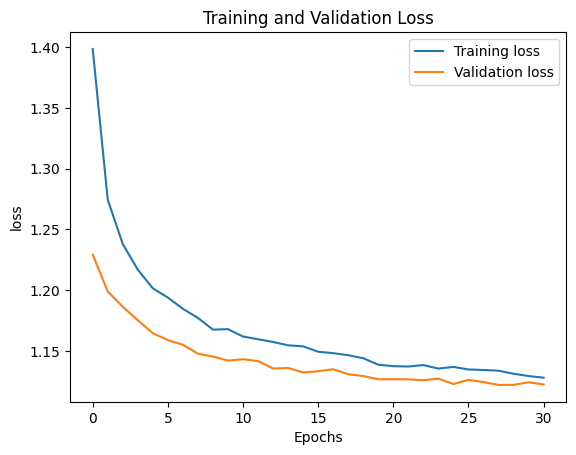

62/62 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       962
           1       0.40      0.48      0.44       616
           2       0.55      0.03      0.06       199
           3       0.50      0.05      0.09        83
           4       0.00      0.00      0.00        39
           5       0.00      0.00      0.00        77

    accuracy                           0.56      1976
   macro avg       0.35      0.23      0.22      1976
weighted avg       0.52      0.56      0.50      1976



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [247]:
ann = ann_factory()
hist = ann.fit(
    X_train, to_categorical(y_train),
    validation_data=(X_val, to_categorical(y_val)), 
    callbacks=[EarlyStopping(patience=3)],
    epochs=200,
    batch_size=64)
plot_train_history(hist)
print(classification_report(y_test, np.argmax(ann.predict(X_test), axis=-1)))

## Cascading bins waterfall model

In [263]:
import collections.abc

def isMonotonicallyIncreasing(array):
    a = np.array(array)
    return np.all(a[:-1] < a[1:])
    
class CBWM:
    def __init__(
        self, 
        bins, 
        models = lambda : GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0),
    ):
        if isinstance(bins, str) or not hasattr(bins, '__len__'):
            raise TypeError('bins must be Sequence')
        if len(bins) == 0:
            raise ValueError('bins cannot be empty Sequence')
        if not isMonotonicallyIncreasing(bins):
            raise ValueError('bins must be monotonically increasing Sequence')
        
        self.bins = bins
        
        if not isinstance(models, str) and hasattr(models, '__len__'):
            if (len(models) == len(self.bins) - 2):
                self.models = models
            else:
                raise ValueError('len(models) == len(self.bins) - 2')
        elif (callable(models)):
            self.models = [models() for _ in range(len(self.bins) - 2)]
        else:
            raise TypeError('models must be Sequence or callable (model factory)')
        
        
    def fit(self, X, y):
        x_next = X
        y_next = y
        for bin_edge, model in zip(self.bins[1:-1], self.models):
            y_bin = (y_next < bin_edge).astype(int)

            model.fit(x_next, y_bin)
            
            next_idx = y_bin == 0
            x_next = x_next[next_idx]
            y_next = y_next[next_idx]
            
    def predict(self, X):
        y_shape = (X.shape[0], )
        y_pred = np.full(y_shape, 0, dtype=int)
        
        for idx, model in enumerate(self.models):
            pred_not_done = y_pred == 0
            if not pred_not_done.any():
                break
            pred_done = model.predict(X[pred_not_done]) == 1
            y_pred[pred_not_done] = pred_done.astype(int) * (idx + 1)
        
        y_pred[y_pred==0] = len(self.models) + 1
        
        return y_pred - 1


In [264]:
cmwm = CBWM(bins)
fit_print(cmwm, X_train, y_train_orig, X_test, y_test)

              precision    recall  f1-score   support

    0-7 days       0.73      0.74      0.74       962
   7-30 days       0.45      0.47      0.46       616
  30-60 days       0.34      0.20      0.25       199
  60-90 days       0.36      0.19      0.25        83
 90-120 days       0.23      0.08      0.12        39
  > 120 days       0.17      0.39      0.23        77

    accuracy                           0.55      1976
   macro avg       0.38      0.35      0.34      1976
weighted avg       0.56      0.55      0.55      1976



In [269]:
gb_t_params = {'subsample': 0.8, 'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 8, 'learning_rate': 0.01}
rf_t_params = {'n_estimators': 60, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}

gb_t_params = {'subsample': 0.8, 'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 8, 'learning_rate': 0.05}


# models = [
#     RandomForestClassifier(**rf_t_params, random_state=0),
#     RandomForestClassifier(**rf_t_params, random_state=0),
#     RandomForestClassifier(**rf_t_params, random_state=0),
#     RandomForestClassifier(**rf_t_params, random_state=0),
#     RandomForestClassifier(**rf_t_params, random_state=0),
# ]

cmwm = CBWM(bins, lambda: GradientBoostingClassifier(**gb_t_params, random_state=0))
cmwm.fit(X_train, y_train_orig)
print_report(y_test, cmwm.predict(X_test), target_labels)

              precision    recall  f1-score   support

    0-7 days       0.73      0.74      0.74       962
   7-30 days       0.45      0.48      0.46       616
  30-60 days       0.37      0.21      0.27       199
  60-90 days       0.35      0.18      0.24        83
 90-120 days       0.00      0.00      0.00        39
  > 120 days       0.16      0.35      0.22        77

    accuracy                           0.55      1976
   macro avg       0.34      0.33      0.32      1976
weighted avg       0.55      0.55      0.55      1976



# SMOTE

In [8]:
from imblearn.over_sampling import SMOTE

<Axes: title={'center': 'Class distribution before SMOTE'}>

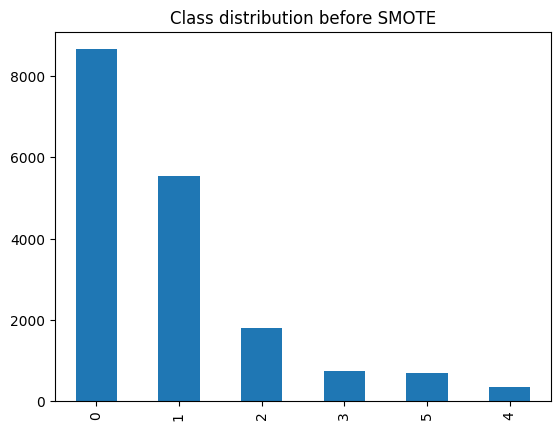

In [9]:
pd.Series(y_train).value_counts().plot(kind='bar', title='Class distribution before SMOTE')

<Axes: title={'center': 'Class distribution after appying SMOTE'}>

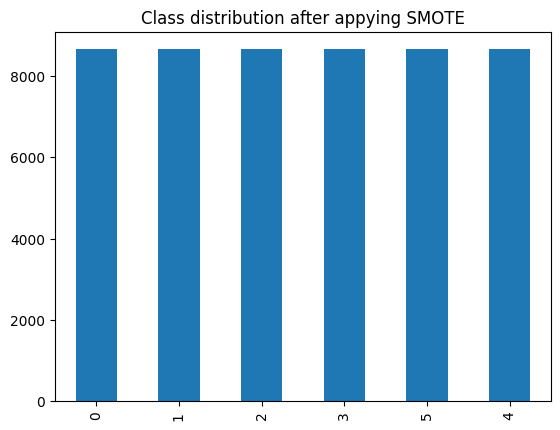

In [10]:
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X_train, y_train)
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE')

In [11]:
# cats
rf_smote_params = {'n_estimators':40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 15, 'bootstrap': True}

# dogs
rf_smote_params = {'n_estimators': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 6, 'bootstrap': True}

rf = RandomForestClassifier(**rf_smote_params, random_state=0)
fit_print(rf, X_resampled, y_resampled, X_test, y_test)

              precision    recall  f1-score   support

    0-7 days       0.68      0.79      0.73       962
   7-30 days       0.45      0.33      0.38       616
  30-60 days       0.37      0.21      0.26       199
  60-90 days       0.39      0.16      0.22        83
 90-120 days       0.03      0.05      0.04        39
  > 120 days       0.16      0.39      0.22        77

    accuracy                           0.53      1976
   macro avg       0.35      0.32      0.31      1976
weighted avg       0.53      0.53      0.52      1976



In [16]:
# cats
gb_smote_params = {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 8, 'learning_rate': 0.1}
# gb_smote_params = {'subsample': 0.8, 'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.05}

# dogs
gb_smote_params = {'subsample': 0.8, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.05}


gb = GradientBoostingClassifier(**gb_smote_params, random_state=0)
fit_print(gb, X_resampled, y_resampled, X_test, y_test)

              precision    recall  f1-score   support

    0-7 days       0.71      0.76      0.73       962
   7-30 days       0.45      0.41      0.43       616
  30-60 days       0.46      0.18      0.26       199
  60-90 days       0.25      0.22      0.23        83
 90-120 days       0.04      0.10      0.06        39
  > 120 days       0.18      0.34      0.24        77

    accuracy                           0.54      1976
   macro avg       0.35      0.33      0.33      1976
weighted avg       0.55      0.54      0.54      1976



In [21]:
xgb_smote_params = {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1}
xgb_smote_params = {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.1}

xgb_smote_params = {'subsample': 1.0, 'n_estimators': 60, 'max_depth': 8, 'learning_rate': 0.05}

xgb =  XGBClassifier(**xgb_smote_params, objective="multi:softprob", random_state=0)
fit_print(xgb, X_resampled, y_resampled, X_test, y_test)

              precision    recall  f1-score   support

    0-7 days       0.70      0.79      0.74       962
   7-30 days       0.45      0.40      0.42       616
  30-60 days       0.42      0.22      0.29       199
  60-90 days       0.31      0.20      0.25        83
 90-120 days       0.03      0.08      0.05        39
  > 120 days       0.21      0.29      0.24        77

    accuracy                           0.55      1976
   macro avg       0.36      0.33      0.33      1976
weighted avg       0.54      0.55      0.54      1976



In [24]:
train, val, test = train_val_test_prep(df)

X_train, y_train = train.drop(columns=['time_in_shelter_days', 'target']), train['target']
X_train, y_train = SMOTE(random_state=0).fit_resample(X_train, y_train)
X_val, y_val = val.drop(columns=['time_in_shelter_days', 'target']), val['target']
X_test, y_test = test.drop(columns=['time_in_shelter_days', 'target']), test['target']

X_train.shape, X_val.shape, X_test.shape, y_train.value_counts(),  y_val.value_counts(),  y_test.value_counts()

((46146, 41),
 (1974, 41),
 (1976, 41),
 1    7691
 5    7691
 0    7691
 2    7691
 3    7691
 4    7691
 Name: target, dtype: int64,
 0    961
 1    615
 2    199
 3     83
 5     77
 4     39
 Name: target, dtype: int64,
 0    962
 1    616
 2    199
 3     83
 5     77
 4     39
 Name: target, dtype: int64)

In [31]:
def ann_factory_smote(metrics =['accuracy']):
  ann = Sequential()
  ann.add(Dense(128, input_shape=(X_train.shape[1], ), activation='relu', kernel_regularizer=l2(0.0001)))
  ann.add(Dropout(0.5))
  ann.add(Dense(64, input_shape=(X_train.shape[1], ), activation='relu', kernel_regularizer=l2(0.0001)))
  ann.add(Dropout(0.5))
  ann.add(Dense(len(bins) - 1, activation='softmax'))
  ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
  return ann

Epoch 1/200
722/722 [==============================] - 3s 3ms/step - loss: 1.7029 - accuracy: 0.2642 - val_loss: 1.5120 - val_accuracy: 0.4174
Epoch 2/200
722/722 [==============================] - 2s 2ms/step - loss: 1.5976 - accuracy: 0.3319 - val_loss: 1.4728 - val_accuracy: 0.4149
Epoch 3/200
722/722 [==============================] - 2s 2ms/step - loss: 1.5623 - accuracy: 0.3517 - val_loss: 1.3856 - val_accuracy: 0.4463
Epoch 4/200
722/722 [==============================] - 2s 2ms/step - loss: 1.5376 - accuracy: 0.3685 - val_loss: 1.4102 - val_accuracy: 0.4529
Epoch 5/200
722/722 [==============================] - 2s 2ms/step - loss: 1.5150 - accuracy: 0.3814 - val_loss: 1.4195 - val_accuracy: 0.4448
Epoch 6/200
722/722 [==============================] - 2s 2ms/step - loss: 1.4988 - accuracy: 0.3921 - val_loss: 1.4443 - val_accuracy: 0.4433


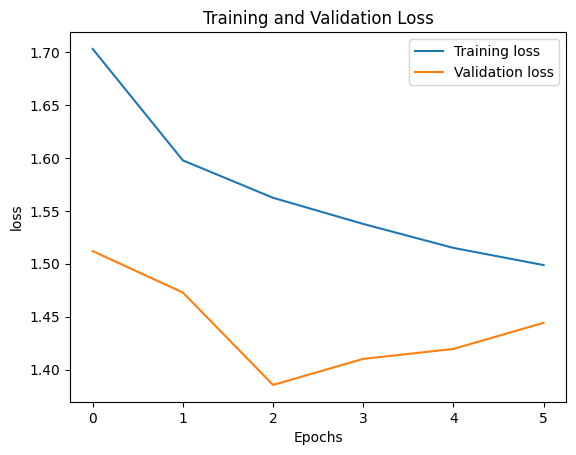

62/62 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       962
           1       0.40      0.18      0.25       616
           2       0.16      0.21      0.18       199
           3       0.13      0.12      0.12        83
           4       0.02      0.10      0.03        39
           5       0.12      0.42      0.19        77

    accuracy                           0.43      1976
   macro avg       0.26      0.28      0.25      1976
weighted avg       0.50      0.43      0.44      1976



In [32]:
ann = ann_factory_smote()
hist = ann.fit(
    X_train, to_categorical(y_train),
    validation_data=(X_val, to_categorical(y_val)), 
    callbacks=[EarlyStopping(patience=3)],
    epochs=200,
    batch_size=64)
plot_train_history(hist)
print(classification_report(y_test, np.argmax(ann.predict(X_test), axis=-1)))